In [ ]:
# 1. Install the Kaggle library
!pip install -q kaggle

# 2. Upload your Kaggle API credentials ('kaggle.json' file)
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# 3. Configure the Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nKaggle API configured successfully!")

# 4. Download and unzip the dataset
!kaggle datasets download -d phylake1337/fire-dataset
!unzip -q fire-dataset.zip

print("\nDataset downloaded and unzipped! ✅")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API configured successfully!
Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
 90% 348M/387M [00:00<00:00, 428MB/s]
100% 387M/387M [00:00<00:00, 479MB/s]

Dataset downloaded and unzipped! ✅


Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.

New Keras Class Assignments:
{'fire_images': 0, 'non_fire_images': 1}
This should now correctly show 2 classes: {'fire_images': 0, 'non_fire_images': 1}


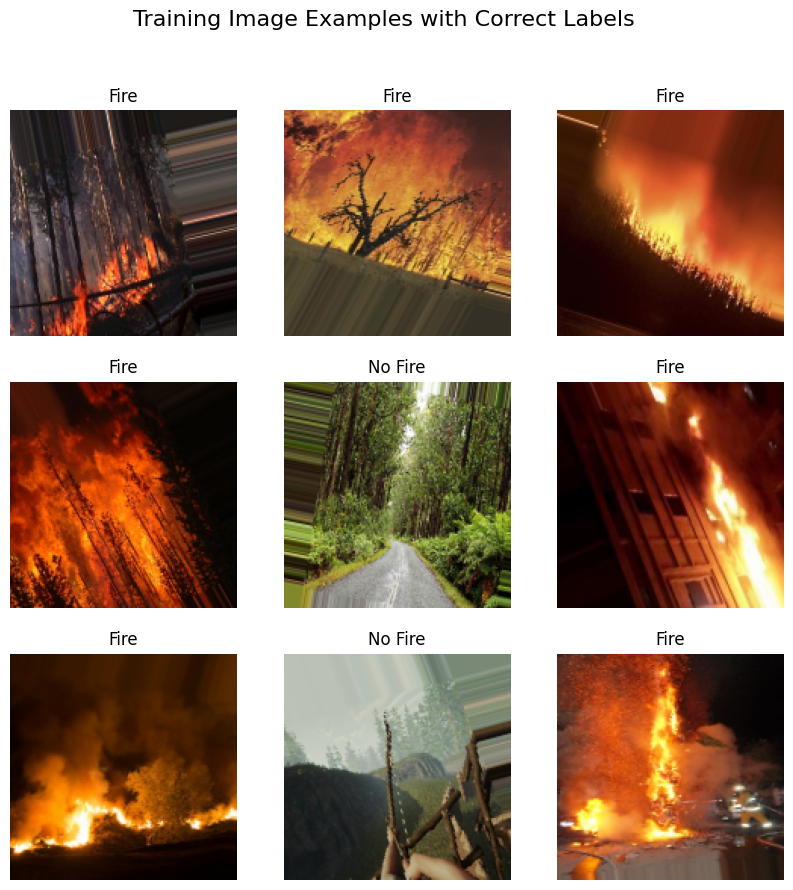

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define image settings
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# --- PATH ---
# Point to the directory that CONTAINS the 'fire_images' and 'non_fire_images' folders.
base_dir = './fire_dataset/'

# Create data generators with augmentation and a 20% validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create the training generator from the correct directory
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Create the validation generator from the correct directory
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# --- VERIFY THE FIX ---
print("\nNew Keras Class Assignments:")
print(train_generator.class_indices)
print("This should now correctly show 2 classes: {'fire_images': 0, 'non_fire_images': 1}")

# --- Visualize some training images with CORRECTED labels ---
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(min(9, len(images))): # Ensure we don't go out of bounds
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Fire" if labels[i] == 0 else "No Fire")
        plt.axis("off")
    break
plt.suptitle("Training Image Examples with Correct Labels", fontsize=16)
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained MobileNetV2 model without its top classification layer
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add our own custom layers on top for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# Final output layer with one neuron for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()

/tmp/ipython-input-2821249947.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

print("\nModel training complete! 🚀")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7741 - loss: 0.6334 - val_accuracy: 0.9196 - val_loss: 0.2382
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9604 - loss: 0.1153 - val_accuracy: 0.9497 - val_loss: 0.1370
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9501 - loss: 0.1473 - val_accuracy: 0.9548 - val_loss: 0.1482
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9657 - loss: 0.0843 - val_accuracy: 0.9347 - val_loss: 0.1908
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9624 - loss: 0.0831 - val_accuracy: 0.9598 - val_loss: 0.1794
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9655 - loss: 0.0826 - val_accuracy: 0.9296 - val_loss: 0.2152
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9629 - loss: 0.0956 - val_accuracy: 0.9648 - val_loss: 0.1422
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9810 - loss: 0.0661 - val_accuracy: 0.9497 - val_loss:

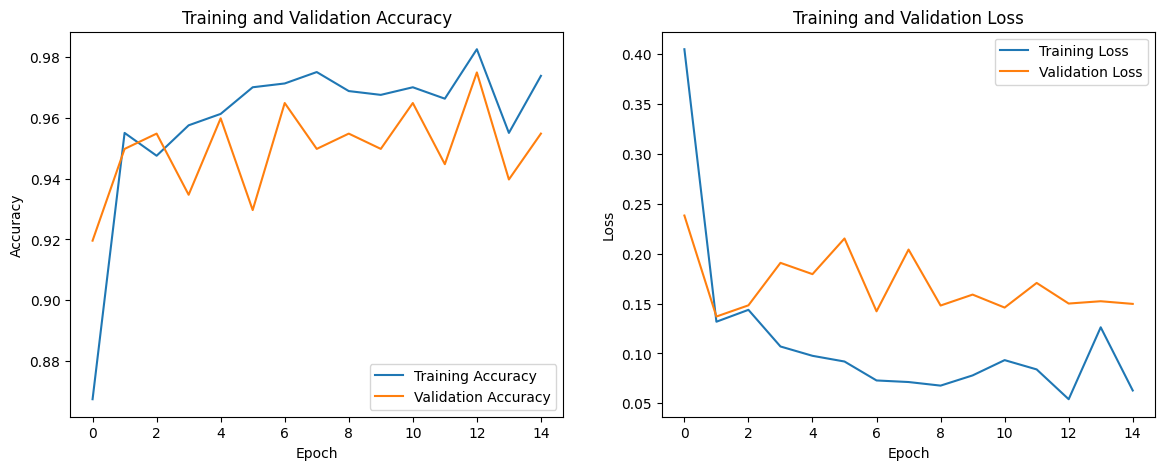

In [ ]:
# Extract the accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# --- Plot Training and Validation Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# --- Plot Training and Validation Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plots
plt.show()

Found 199 images belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

Model AUC Score: 0.9858


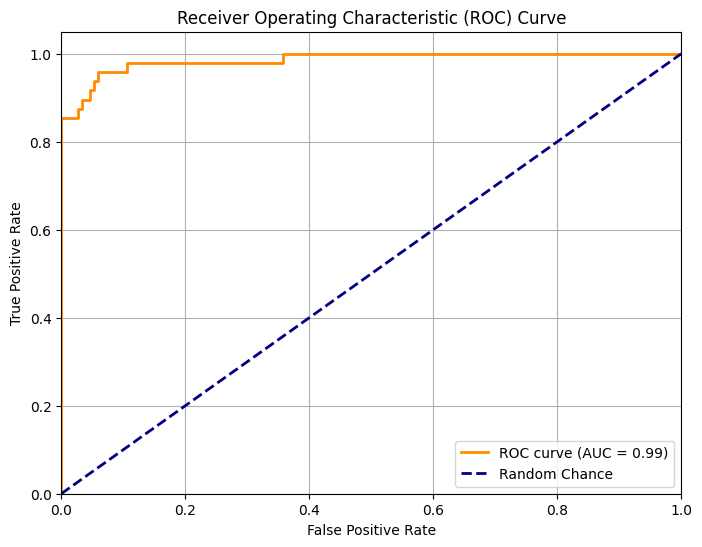

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Get Predictions and True Labels ---
# To ensure the order of predictions matches the labels, it's best to create
# a new generator for the validation set with shuffling turned off.
eval_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Important: Do not shuffle for evaluation
)

# Get the true labels from the generator
y_true = eval_generator.classes

# Get the predicted probabilities from the model
# Remember: low value = fire (class 0), high value = no fire (class 1)
y_pred_probs = model.predict(eval_generator)

# --- Calculate ROC and AUC ---
# Note: roc_curve expects probabilities for the "positive" class.
# In our case, the positive class is 'non_fire_images' (class 1).
# The model's output already represents this, so we can use it directly.
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc = roc_auc_score(y_true, y_pred_probs)

print(f"\nModel AUC Score: {auc:.4f}")

# --- Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Please upload an image to test the model:


Saving TheSupplyCache-380896-wildland-firefighter-system-Image1.jpg to TheSupplyCache-380896-wildland-firefighter-system-Image1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


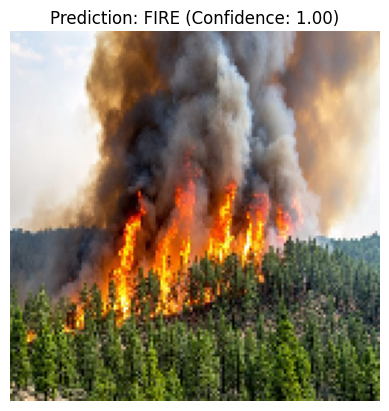

🚨 The model predicts: **FIRE** with 1.00 confidence.


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch
    img_array /= 255.0 # Rescale

    # Make the prediction
    prediction = model.predict(img_array)[0][0]

    # --- CORRECTED PREDICTION LOGIC ---
    # The model outputs the probability of being class 1 ('non_fire_images').
    # Therefore, a LOW value (< 0.5) means it's likely class 0 ('fire_images').
    if prediction < 0.5:
        is_fire = True
        confidence = 1 - prediction
    else:
        is_fire = False
        confidence = prediction

    # Display the result
    plt.imshow(img)
    plt.axis('off')
    result_text = f"Prediction: {'FIRE' if is_fire else 'NO FIRE'} (Confidence: {confidence:.2f})"
    plt.title(result_text)
    plt.show()

    if is_fire:
        print(f"🚨 The model predicts: **FIRE** with {confidence:.2f} confidence.")
    else:
        print(f"✅ The model predicts: **NO FIRE** with {confidence:.2f} confidence.")

# --- Upload and test your image ---
print("Please upload an image to test the model:")
uploaded = files.upload()

for fn in uploaded.keys():
    predict_image('/content/' + fn)

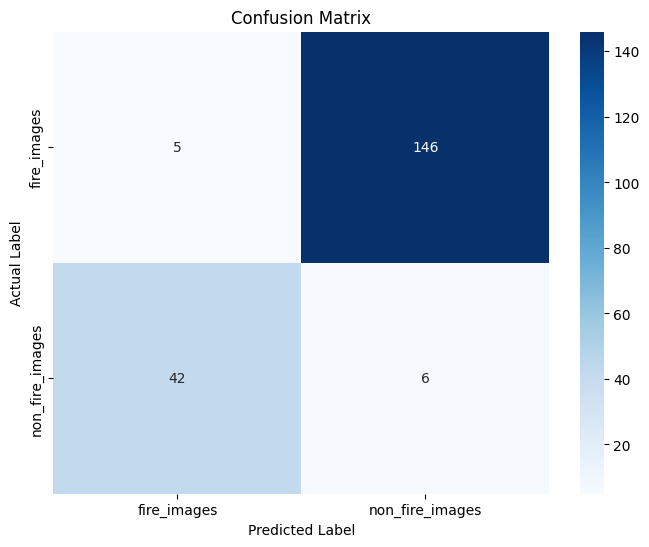

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# We already have y_true and y_pred_probs from the ROC step.
# Let's get the final class predictions by thresholding at 0.5.
# Remember: prediction < 0.5 means class 0 (fire).
y_pred = (y_pred_probs < 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get the class names from the generator
class_names = list(eval_generator.class_indices.keys())
# Important: We need to sort them to match the label indices (0, 1)
class_names.sort(key=lambda x: eval_generator.class_indices[x])


# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                 precision    recall  f1-score   support

    fire_images       0.11      0.03      0.05       151
non_fire_images       0.04      0.12      0.06        48

       accuracy                           0.06       199
      macro avg       0.07      0.08      0.06       199
   weighted avg       0.09      0.06      0.05       199



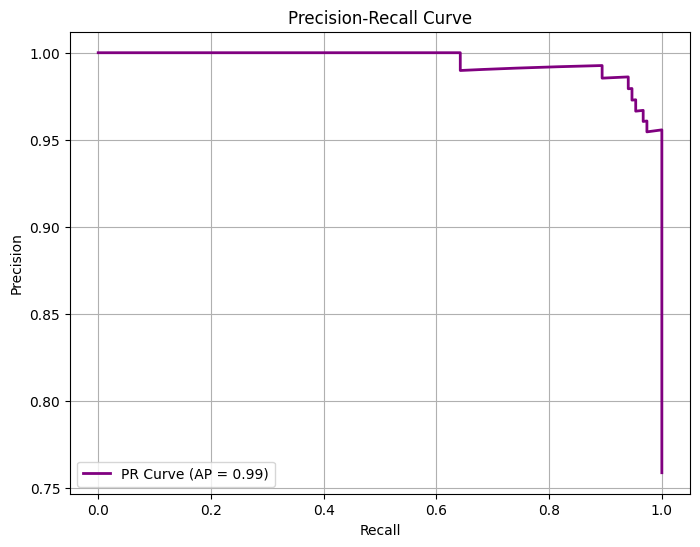

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# For the PR curve, we need the probability of the "positive" class.
# Our model predicts P(class=1), but 'fire' is class 0. So, we need P(class=0).
# P(class=0) = 1 - P(class=1)
# And the true labels need to be flipped too (1 for fire, 0 for no fire).
y_true_flipped = 1 - y_true
y_pred_probs_flipped = 1 - y_pred_probs

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true_flipped, y_pred_probs_flipped)
ap = average_precision_score(y_true_flipped, y_pred_probs_flipped)


# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Plotting Enhancements (run this once) ---

# Set a stylish seaborn aesthetic
sns.set_style("whitegrid")

# Define a custom color palette for consistent colors
# This is the line that fixes the error
fire_colors = ["#FF5733", "#337DFF"] # Red for Fire, Blue for No Fire

plt.rcParams.update({
    'font.size': 12,        # General font size
    'axes.titlesize': 14,   # Title font size
    'axes.labelsize': 12,   # Axis label font size
    'xtick.labelsize': 10,  # X-axis tick label size
    'ytick.labelsize': 10,  # Y-axis tick label size
    'legend.fontsize': 10,  # Legend font size
    'figure.titlesize': 16, # Figure title size
    'figure.dpi': 100,      # High resolution for figures
    'figure.figsize': (10, 6) # Default figure size
})

print("Global plotting styles set! 🎉 The 'fire_colors' variable is now defined.")

Global plotting styles set! 🎉 The 'fire_colors' variable is now defined.


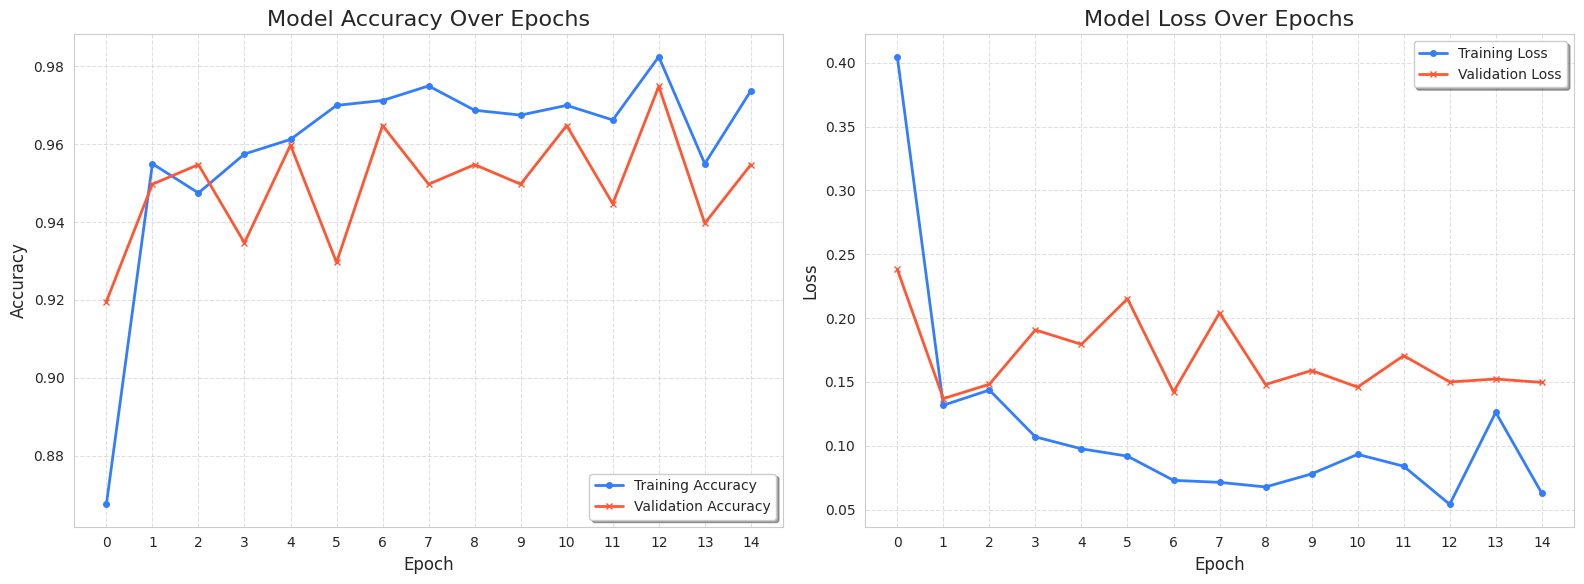

In [ ]:
# Extract the accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

# Create a figure with two subplots
plt.figure(figsize=(16, 6)) # Wider figure for better separation

# --- Plot Training and Validation Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color=fire_colors[1], marker='o', markersize=4, linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color=fire_colors[0], marker='x', markersize=4, linewidth=2)
plt.legend(loc='lower right', frameon=True, shadow=True)
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(epochs_range) # Show all epoch numbers

# --- Plot Training and Validation Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color=fire_colors[1], marker='o', markersize=4, linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color=fire_colors[0], marker='x', markersize=4, linewidth=2)
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(epochs_range) # Show all epoch numbers

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show()

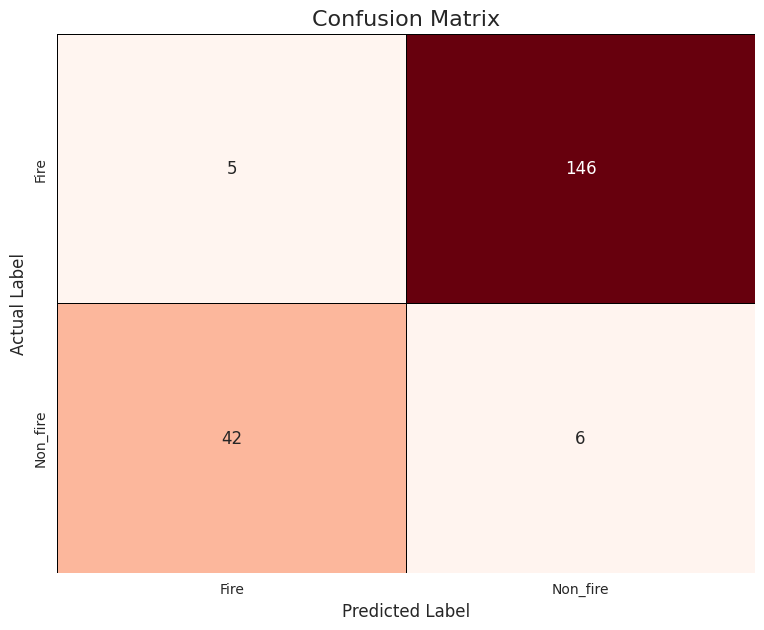


Classification Report:
              precision    recall  f1-score   support

        Fire       0.11      0.03      0.05       151
    Non_fire       0.04      0.12      0.06        48

    accuracy                           0.06       199
   macro avg       0.07      0.08      0.06       199
weighted avg       0.09      0.06      0.05       199



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# (Ensure y_true and y_pred_probs are defined from previous cells)

# Get the final class predictions (remembering fire_images is class 0)
y_pred = (y_pred_probs < 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get the class names from the generator and ensure correct order
class_labels = {v: k for k, v in eval_generator.class_indices.items()}
class_names = [class_labels[0].replace('_images', '').capitalize(),
               class_labels[1].replace('_images', '').capitalize()]


# Plot the confusion matrix using seaborn
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', # Use a warm color for fire context
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='black', cbar=False) # Added lines for separation
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Improve labels for clarity if needed (e.g., 'Fire' instead of 'fire_images')
# ax.set_xticklabels([f"Predicted {name}" for name in class_names])
# ax.set_yticklabels([f"Actual {name}" for name in class_names])

plt.show()

# --- Classification Report (text-based, but crucial) ---
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))